# 9. Data Aggregation and Group Operations

o padnas는  groupby 라는 데이터 집합을 나누고 요약할 수 있는 방법 제공

o 이 장의 주요 내용
1. 하나 이상의 키(함수, 배열, DataFrame의 칼럼 이름)를 이용해 pandas 객체를 여러 조각으로 나누는 법
2. 합계, 평균, 표준편차, 사용자 정의 함수 같은 그룹 요약통계를 계산
3. DataFrame의 각 칼럼에 다양한 함수를 적용
4. 정규화, 선형 회귀, 등급, 부분집합 선택 같은 집단 내 변형 적용
5. 피벗 테이블과 교차일람표 구하는 법
6. 변위치 분석과 다른 데이터 파생 집단 분석

* 시계열 데이터 집계 같은 특수한 groupby 사용 방법인 리샘플링은 10장에서 다룰 예정

In [2]:
from __future__ import division
from numpy.random import randn
import numpy as np
import os
import matplotlib.pyplot as plt
np.random.seed(12345)
plt.rc('figure', figsize=(10, 6))
from pandas import Series, DataFrame
import pandas as pd
np.set_printoptions(precision=4)

In [3]:
pd.options.display.notebook_repr_html = False

In [4]:
%matplotlib inline

## 9.1 GroupBy mechanics

#### o 그룹 연산: 분리-적용-결합
1. 분리(splitting): Series. DataFrame과 같은 pandas 객체나 다른 객체에 들어 있는 데이터를 하나 이상의 색인을 기준으로 분리. (분리 기준: row(axis=0)나 column(axis=1))
2. 적용(applying): 함수를 각 그룹에 적용시켜 새로운 값을 얻어냄.
3. 결합(combining): 함수를 적용한 결과를 하나의 객체로 결합. 결과를 담는 객체는 보통 데이터에 어떤 '연산'을 했는지에 따라 결정.
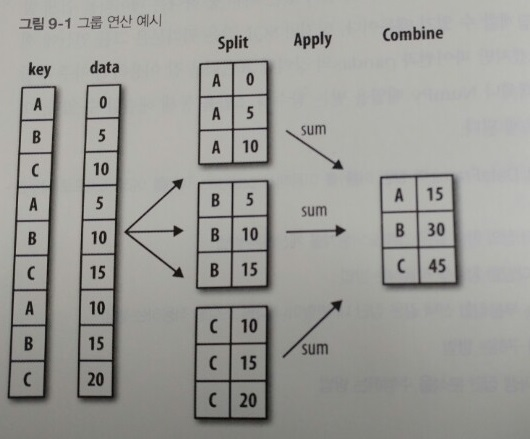

#### o 그룹 색인의 형태
1. 그룹으로 묶을 축과 같은 길이의 리스트나 배열
2. DataFrame의 칼럼 이름을 지칭하는 값
3. 그룹으로 묶을 값과 그룹 이름에 대응하는 사전이나 Series 객체
4. 축 색인 또는 색인 내의 개별 이름에 대해 실행되는 함수

#### o DataFrame.groupby(by=None, axis=0, level=None, as_index=True, sort=True, group_keys=True, squeeze=False, **kwargs)
- https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.groupby.html
- Group series using mapper (dict or key function, apply given function to group, return result as series) or by a series of columns.
- Parameters
 - by : mapping, function, str, or iterable
   - Used to determine the groups for the groupby. If by is a function, it’s called on each value of the object’s index. If a dict or Series is passed, the Series or dict VALUES will be used to determine the groups (the Series’ values are first aligned; see .align() method). If an ndarray is passed, the values are used as-is determine the groups. A str or list of strs may be passed to group by the columns in self
 - axis : int, default 0
 - level : int, level name, or sequence of such, default None
   If the axis is a MultiIndex (hierarchical), group by a particular level or levels
 - as_index : boolean, default True
  - For aggregated output, return object with group labels as the index. Only relevant for DataFrame input. as_index=False is effectively “SQL-style” grouped output
  
#### o key1으로 그룹하여, data1 의 값을 구해보자. 

In [5]:
df = DataFrame({'key1' : ['a', 'a', 'b', 'b', 'a'],
                'key2' : ['one', 'two', 'one', 'two', 'one'],
                'data1' : np.random.randn(5),
                'data2' : np.random.randn(5)})
df

      data1     data2 key1 key2
0 -0.204708  1.393406    a  one
1  0.478943  0.092908    a  two
2 -0.519439  0.281746    b  one
3 -0.555730  0.769023    b  two
4  1.965781  1.246435    a  one

#### groupby object
- https://pandas.pydata.org/pandas-docs/version/0.20/groupby.html#groupby-object-attributes
- The groups attribute is a dict 
  - keys are the computed unique groups 
  - corresponding values are the axis labels belonging to each group.

In [6]:
grouped = df['data1'].groupby(df['key1'])
grouped

In [7]:
grouped.mean()

key1
a    0.746672
b   -0.537585
Name: data1, dtype: float64

In [8]:
# Multiple Key groups
means = df['data1'].groupby([df['key1'], df['key2']]).mean()
means

key1  key2
a     one     0.880536
      two     0.478943
b     one    -0.519439
      two    -0.555730
Name: data1, dtype: float64

In [9]:
means.unstack()

key2       one       two
key1                    
a     0.880536  0.478943
b    -0.519439 -0.555730

####  o groupby 객체를 얻을 때, 사용한 Series는 길이만 같다면 다른 배열을 활용 가능

In [10]:
states = np.array(['Ohio', 'California', 'California', 'Ohio', 'Ohio'])
years = np.array([2005, 2005, 2006, 2005, 2006])
df['data1'].groupby([states, years]).mean()

California  2005    0.478943
            2006   -0.519439
Ohio        2005   -0.380219
            2006    1.965781
Name: data1, dtype: float64

#### o DataFrame의 경우, groupby 할 값을 그 안에서 찾음 
예) 컬럼을 그룹색인으로 사용하는 경우 

In [11]:
df.groupby('key1').mean()
# 주의: key2는 숫자가 아니므로 제거됨.

         data1     data2
key1                    
a     0.746672  0.910916
b    -0.537585  0.525384

In [12]:
df.groupby(['key1', 'key2']).mean()

              data1     data2
key1 key2                    
a    one   0.880536  1.319920
     two   0.478943  0.092908
b    one  -0.519439  0.281746
     two  -0.555730  0.769023

#### o groupby.size()
- 그룹의 크기를 Series로 반환 

In [13]:
df.groupby(['key1', 'key2']).size()

key1  key2
a     one     2
      two     1
b     one     1
      two     1
dtype: int64

### 9.1.1 그룹간 순회하기(Iterating over groups)
#### o GroupBy 객체는 Iteration을 지원
 - 그룹이름과 관련 데이터를 묶은 튜플로 반환하는 Iterable 
 

In [14]:
for name, group in df.groupby('key1'):
    print(name)
    print(group)

a
      data1     data2 key1 key2
0 -0.204708  1.393406    a  one
1  0.478943  0.092908    a  two
4  1.965781  1.246435    a  one
b
      data1     data2 key1 key2
2 -0.519439  0.281746    b  one
3 -0.555730  0.769023    b  two


#### o 두개의 key를 사용하는 iterable

In [15]:
for (k1, k2), group in df.groupby(['key1', 'key2']):
    print((k1, k2))
    print(group)

('a', 'one')
      data1     data2 key1 key2
0 -0.204708  1.393406    a  one
4  1.965781  1.246435    a  one
('a', 'two')
      data1     data2 key1 key2
1  0.478943  0.092908    a  two
('b', 'one')
      data1     data2 key1 key2
2 -0.519439  0.281746    b  one
('b', 'two')
     data1     data2 key1 key2
3 -0.55573  0.769023    b  two


#### o 원하는 그룹만 얻는 방법 : 튜를로 사전을 만들어 지정

In [16]:
pieces = dict(list(df.groupby('key1')))
pieces['b']

      data1     data2 key1 key2
2 -0.519439  0.281746    b  one
3 -0.555730  0.769023    b  two

In [17]:
df.dtypes

data1    float64
data2    float64
key1      object
key2      object
dtype: object

In [18]:
df

      data1     data2 key1 key2
0 -0.204708  1.393406    a  one
1  0.478943  0.092908    a  two
2 -0.519439  0.281746    b  one
3 -0.555730  0.769023    b  two
4  1.965781  1.246435    a  one

In [19]:
# axis=0 일때 key1의 값에  따라 행을 그룹화함.
# axis=1 일때 행의 값에 따라, 열을 그룹화함.
grouped = df.groupby(df.dtypes, axis=1)
# grouped = df.groupby(df.dtypes)
# grouped
dict(list(grouped))

{dtype('float64'):       data1     data2
 0 -0.204708  1.393406
 1  0.478943  0.092908
 2 -0.519439  0.281746
 3 -0.555730  0.769023
 4  1.965781  1.246435, dtype('O'):   key1 key2
 0    a  one
 1    a  two
 2    b  one
 3    b  two
 4    a  one}

### 9.1.2 컬럼 도는 컬럼의 일부만 선택하기(Selecting a column or subset of columns)

#### o 대용량  DataFrame에서 소수 컬럼의 값 얻기 

In [20]:
df.groupby(['key1', 'key2'])[['data2']].mean()

              data2
key1 key2          
a    one   1.319920
     two   0.092908
b    one   0.281746
     two   0.769023

In [21]:
s_grouped = df.groupby(['key1', 'key2'])['data2']
s_grouped

In [22]:
s_grouped.mean()

key1  key2
a     one     1.319920
      two     0.092908
b     one     0.281746
      two     0.769023
Name: data2, dtype: float64

### 9.1.3 Grouping with dicts and Series
o 배열이 아닌 형태의 그루핑
1) DataFrame의 경우

In [23]:
people = DataFrame(np.random.randn(5, 5),
                   columns=['a', 'b', 'c', 'd', 'e'],
                   index=['Joe', 'Steve', 'Wes', 'Jim', 'Travis'])
people.ix[2:3, ['b', 'c']] = np.nan # Add a few NA values
people

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  after removing the cwd from sys.path.


               a         b         c         d         e
Joe     1.007189 -1.296221  0.274992  0.228913  1.352917
Steve   0.886429 -2.001637 -0.371843  1.669025 -0.438570
Wes    -0.539741       NaN       NaN -1.021228 -0.577087
Jim     0.124121  0.302614  0.523772  0.000940  1.343810
Travis -0.713544 -0.831154 -2.370232 -1.860761 -0.860757

In [24]:
mapping = {'a': 'red', 'b': 'red', 'c': 'blue',
           'd': 'blue', 'e': 'red', 'f' : 'orange'}

In [25]:
by_column = people.groupby(mapping, axis=1)
by_column.sum()

            blue       red
Joe     0.503905  1.063885
Steve   1.297183 -1.553778
Wes    -1.021228 -1.116829
Jim     0.524712  1.770545
Travis -4.230992 -2.405455

2) Series의 경우

In [26]:
map_series = Series(mapping)
map_series

a       red
b       red
c      blue
d      blue
e       red
f    orange
dtype: object

In [27]:
people.groupby(map_series, axis=1).count()

        blue  red
Joe        2    3
Steve      2    3
Wes        1    2
Jim        2    3
Travis     2    3

### 9.1.4 함수로 그룹화하기(Grouping with functions) 
o 주어진 함수는 색인에 적용된 반환값을 그루핑 값으로 사용

In [28]:
people.groupby(len).sum()
# people.groupby().sum()

          a         b         c         d         e
3  0.591569 -0.993608  0.798764 -0.791374  2.119639
5  0.886429 -2.001637 -0.371843  1.669025 -0.438570
6 -0.713544 -0.831154 -2.370232 -1.860761 -0.860757

In [29]:
# (3 one) 그룹에 Joe, Wes 포함, (3 two)에 Jim 이 해당 
key_list = ['one', 'one', 'one', 'two', 'two']
people.groupby([len, key_list]).min()

              a         b         c         d         e
3 one -0.539741 -1.296221  0.274992 -1.021228 -0.577087
  two  0.124121  0.302614  0.523772  0.000940  1.343810
5 one  0.886429 -2.001637 -0.371843  1.669025 -0.438570
6 two -0.713544 -0.831154 -2.370232 -1.860761 -0.860757

### 9.1.5 색인 단계로 그룹화(Grouping by index levels)

In [30]:
columns = pd.MultiIndex.from_arrays([['US', 'US', 'US', 'JP', 'JP'],
                                    [1, 3, 5, 1, 3]], names=['cty', 'tenor'])
hier_df = DataFrame(np.random.randn(4, 5), columns=columns)
hier_df

cty          US                            JP          
tenor         1         3         5         1         3
0      0.560145 -1.265934  0.119827 -1.063512  0.332883
1     -2.359419 -0.199543 -1.541996 -0.970736 -1.307030
2      0.286350  0.377984 -0.753887  0.331286  1.349742
3      0.069877  0.246674 -0.011862  1.004812  1.327195

In [31]:
hier_df.groupby(level='cty', axis=1).count()

cty  JP  US
0     2   3
1     2   3
2     2   3
3     2   3

## 9.2 데이터 집계(Data aggregation)

o 보통 그룹마다 계산한 통계치 값을 산출

In [32]:
df

      data1     data2 key1 key2
0 -0.204708  1.393406    a  one
1  0.478943  0.092908    a  two
2 -0.519439  0.281746    b  one
3 -0.555730  0.769023    b  two
4  1.965781  1.246435    a  one

In [33]:
# 분위치를 활용
grouped = df.groupby('key1')
grouped['data1'].quantile(0.9)

key1
a    1.668413
b   -0.523068
Name: data1, dtype: float64

#### 사용자가 만든 함수를 이용하는 경우: agg나 aggreagate  함수를 이용해 만든 함수를 등록 
o DataFrameGroupBy.agg(arg, *args, **kwargs)
- Aggregate using callable, string, dict, or list of string/callables
- 각 그룹마다 하나의 scholar 집계값을 컬럼마다 계산
- Parameters: 
 - func : Function to use for aggregating the data

In [34]:
def peak_to_peak(arr):
    return arr.max() - arr.min()
grouped.agg(peak_to_peak)

         data1     data2
key1                    
a     2.170488  1.300498
b     0.036292  0.487276

In [35]:
# 종합적인 집계함수 제공 함수 
grouped.describe()

     data1                                                              \
     count      mean       std       min       25%       50%       75%   
key1                                                                     
a      3.0  0.746672  1.109736 -0.204708  0.137118  0.478943  1.222362   
b      2.0 -0.537585  0.025662 -0.555730 -0.546657 -0.537585 -0.528512   

               data2                                                    \
           max count      mean       std       min       25%       50%   
key1                                                                     
a     1.965781   3.0  0.910916  0.712217  0.092908  0.669671  1.246435   
b    -0.519439   2.0  0.525384  0.344556  0.281746  0.403565  0.525384   

                          
           75%       max  
key1                      
a     1.319920  1.393406  
b     0.647203  0.769023  

#### o 표 9-1 최적화된 groupby 메서드 
- count: 그룹 내에 NA가 아닌 값의 수를 반환
- sum: NA가 아닌 값의 합
- mean: NA가 아닌 값의 평균
- median: NA가 아닌 값의 산술 중간 값
- std, var: 편향되지 않은 (n-1을 분모로 하는) 표준 편차와 분산
- min, max: NA가 아닌 값의 최소 값과 최대 값
- prod: NA가 아닌 값의 곱
- first, last: NA가 아닌 값 중 첫번째와 마지막 값

### 9.2.1 컬럼기준 여러함수 응용(Column-wise and multiple function application)


In [36]:
tips = pd.read_csv('ch08/tips.csv')
# Add tip percentage of total bill
tips['tip_pct'] = tips['tip'] / tips['total_bill']
tips[:6]

   total_bill   tip     sex smoker  day    time  size   tip_pct
0       16.99  1.01  Female     No  Sun  Dinner     2  0.059447
1       10.34  1.66    Male     No  Sun  Dinner     3  0.160542
2       21.01  3.50    Male     No  Sun  Dinner     3  0.166587
3       23.68  3.31    Male     No  Sun  Dinner     2  0.139780
4       24.59  3.61  Female     No  Sun  Dinner     4  0.146808
5       25.29  4.71    Male     No  Sun  Dinner     4  0.186240

In [37]:
grouped = tips.groupby(['sex', 'smoker'])

In [38]:
grouped_pct = grouped['tip_pct']
grouped_pct.agg('mean')

sex     smoker
Female  No        0.156921
        Yes       0.182150
Male    No        0.160669
        Yes       0.152771
Name: tip_pct, dtype: float64

In [39]:
grouped_pct.agg(['mean', 'std', peak_to_peak])

                   mean       std  peak_to_peak
sex    smoker                                  
Female No      0.156921  0.036421      0.195876
       Yes     0.182150  0.071595      0.360233
Male   No      0.160669  0.041849      0.220186
       Yes     0.152771  0.090588      0.674707

In [40]:
# 집계 컬럼의 이름 변경
grouped_pct.agg([('foo', 'mean'), ('bar', np.std)])

                    foo       bar
sex    smoker                    
Female No      0.156921  0.036421
       Yes     0.182150  0.071595
Male   No      0.160669  0.041849
       Yes     0.152771  0.090588

In [41]:
functions = ['count', 'mean', 'max']
result = grouped['tip_pct', 'total_bill'].agg(functions)
result

              tip_pct                     total_bill                  
                count      mean       max      count       mean    max
sex    smoker                                                         
Female No          54  0.156921  0.252672         54  18.105185  35.83
       Yes         33  0.182150  0.416667         33  17.977879  44.30
Male   No          97  0.160669  0.291990         97  19.791237  48.33
       Yes         60  0.152771  0.710345         60  22.284500  50.81

In [42]:
result['tip_pct']

               count      mean       max
sex    smoker                           
Female No         54  0.156921  0.252672
       Yes        33  0.182150  0.416667
Male   No         97  0.160669  0.291990
       Yes        60  0.152771  0.710345

In [43]:
ftuples = [('Durchschnitt', 'mean'), ('Abweichung', np.var)]
grouped['tip_pct', 'total_bill'].agg(ftuples)

                   tip_pct              total_bill           
              Durchschnitt Abweichung Durchschnitt Abweichung
sex    smoker                                                
Female No         0.156921   0.001327    18.105185  53.092422
       Yes        0.182150   0.005126    17.977879  84.451517
Male   No         0.160669   0.001751    19.791237  76.152961
       Yes        0.152771   0.008206    22.284500  98.244673

In [44]:
#  
grouped.agg({'tip' : np.max, 'size' : 'sum'})

                tip  size
sex    smoker            
Female No       5.2   140
       Yes      6.5    74
Male   No       9.0   263
       Yes     10.0   150

In [45]:
grouped.agg({'tip_pct' : ['min', 'max', 'mean', 'std'],
             'size' : 'sum'})

                tip_pct                               size
                    min       max      mean       std  sum
sex    smoker                                             
Female No      0.056797  0.252672  0.156921  0.036421  140
       Yes     0.056433  0.416667  0.182150  0.071595   74
Male   No      0.071804  0.291990  0.160669  0.041849  263
       Yes     0.035638  0.710345  0.152771  0.090588  150

### 9.2.2 색인이외의 컬럼으로 집계값 산출
o "as_index = False" 일 경우, 그룹컬럼을 색인 컬럼으로 활용하지 않음.

In [46]:
tips.groupby(['sex', 'smoker'], as_index=False).mean()
# tips.groupby(['sex', 'smoker'], as_index=TRUE).mean()

      sex smoker  total_bill       tip      size   tip_pct
0  Female     No   18.105185  2.773519  2.592593  0.156921
1  Female    Yes   17.977879  2.931515  2.242424  0.182150
2    Male     No   19.791237  3.113402  2.711340  0.160669
3    Male    Yes   22.284500  3.051167  2.500000  0.152771

## 9.3 그룹별 연산과 변형
- 집계는 1차원 배열을 스칼라 값으로 줄여주는 함수를 적용하는 일반적인 데이터 변형의 한 가지 특수한 그룹 연산. 
- 다양한 그룹 연산을 수행할 수 있는 transform과 apply 메서드를 살펴보자.

o 그룹별 평균값 컬럼을 추가하는 작업

In [47]:
df

      data1     data2 key1 key2
0 -0.204708  1.393406    a  one
1  0.478943  0.092908    a  two
2 -0.519439  0.281746    b  one
3 -0.555730  0.769023    b  two
4  1.965781  1.246435    a  one

In [48]:
k1_means = df.groupby('key1').mean().add_prefix('mean_')
k1_means

      mean_data1  mean_data2
key1                        
a       0.746672    0.910916
b      -0.537585    0.525384

In [49]:
pd.merge(df, k1_means, left_on='key1', right_index=True)

      data1     data2 key1 key2  mean_data1  mean_data2
0 -0.204708  1.393406    a  one    0.746672    0.910916
1  0.478943  0.092908    a  two    0.746672    0.910916
4  1.965781  1.246435    a  one    0.746672    0.910916
2 -0.519439  0.281746    b  one   -0.537585    0.525384
3 -0.555730  0.769023    b  two   -0.537585    0.525384

In [50]:
people

               a         b         c         d         e
Joe     1.007189 -1.296221  0.274992  0.228913  1.352917
Steve   0.886429 -2.001637 -0.371843  1.669025 -0.438570
Wes    -0.539741       NaN       NaN -1.021228 -0.577087
Jim     0.124121  0.302614  0.523772  0.000940  1.343810
Travis -0.713544 -0.831154 -2.370232 -1.860761 -0.860757

In [51]:
key = ['one', 'two', 'one', 'two', 'one']
people.groupby(key).mean()

            a         b         c         d         e
one -0.082032 -1.063687 -1.047620 -0.884358 -0.028309
two  0.505275 -0.849512  0.075965  0.834983  0.452620

o groupby.transform(func, *args, **kwargs)
 - 각 그룹마다 func함수를 적용하여, 각 컬럼에 대해 계산한 갑을 그룹화 색인과 동일 차원으로 리턴함. 
 - https://pandas.pydata.org/pandas-docs/stable/groupby.html#transformation

In [52]:
people.groupby(key).transform(np.mean)

               a         b         c         d         e
Joe    -0.082032 -1.063687 -1.047620 -0.884358 -0.028309
Steve   0.505275 -0.849512  0.075965  0.834983  0.452620
Wes    -0.082032 -1.063687 -1.047620 -0.884358 -0.028309
Jim     0.505275 -0.849512  0.075965  0.834983  0.452620
Travis -0.082032 -1.063687 -1.047620 -0.884358 -0.028309

In [53]:
# 그룹별 스칼라 값의 브로드캐스팅
def demean(arr):
    return arr - arr.mean()
demeaned = people.groupby(key).transform(demean)
demeaned

               a         b         c         d         e
Joe     1.089221 -0.232534  1.322612  1.113271  1.381226
Steve   0.381154 -1.152125 -0.447807  0.834043 -0.891190
Wes    -0.457709       NaN       NaN -0.136869 -0.548778
Jim    -0.381154  1.152125  0.447807 -0.834043  0.891190
Travis -0.631512  0.232534 -1.322612 -0.976402 -0.832448

In [54]:
demeaned.groupby(key).mean()

                a             b    c             d    e
one  0.000000e+00 -1.110223e-16  0.0  7.401487e-17  0.0
two -2.775558e-17  0.000000e+00  0.0  0.000000e+00  0.0

### 9.3.1 Apply: 분리-적용-통합
o 가장 일반적인 GropuBy 메쏘드
 - agg(혹은 aggregate) 함수: scholar 값으로 산출
 - transform 함수: 색인과 동일 차원의 결과값 산출 
 
o 객체를 여러조각으로 나누고(split), 조각에 주어진 함수를 일괄 적용(apply), 이를 다시 함침(concat)

o tip_pct의 상위 n개를 리턴하는 함수 작성 (top) 

In [55]:
def top(df, n=5, column='tip_pct'):
    return df.sort_values(by=column)[-n:]
top(tips, n=6)

     total_bill   tip     sex smoker  day    time  size   tip_pct
109       14.31  4.00  Female    Yes  Sat  Dinner     2  0.279525
183       23.17  6.50    Male    Yes  Sun  Dinner     4  0.280535
232       11.61  3.39    Male     No  Sat  Dinner     2  0.291990
67         3.07  1.00  Female    Yes  Sat  Dinner     1  0.325733
178        9.60  4.00  Female    Yes  Sun  Dinner     2  0.416667
172        7.25  5.15    Male    Yes  Sun  Dinner     2  0.710345

#### o GroupBy.apply(func, *args, **kwargs)
- https://pandas.pydata.org/pandas-docs/stable/generated/pandas.core.groupby.GroupBy.apply.html
- Apply function func group-wise and combine the results together.
- Parameters
 - func : function
   - A callable that takes a dataframe as its first argument, and returns a dataframe, a series or a scalar. In addition the callable may take positional and keyword arguments
 - args, kwargs: tuple and dict
   - Optional positional and keyword arguments to pass to func

#### o "smoker"기준 그룹에 top 함수 적용
- https://pandas.pydata.org/pandas-docs/stable/groupby.html#flexible-apply
- 적용과정: 
 - (split) by groupby('smoker')
 - (apply) top fucn to each group
 - (concat) the result of apply funciton with added index of groupby column on hiher level

In [56]:
tips.groupby('smoker').apply(top)

            total_bill   tip     sex smoker   day    time  size   tip_pct
smoker                                                                   
No     88        24.71  5.85    Male     No  Thur   Lunch     2  0.236746
       185       20.69  5.00    Male     No   Sun  Dinner     5  0.241663
       51        10.29  2.60  Female     No   Sun  Dinner     2  0.252672
       149        7.51  2.00    Male     No  Thur   Lunch     2  0.266312
       232       11.61  3.39    Male     No   Sat  Dinner     2  0.291990
Yes    109       14.31  4.00  Female    Yes   Sat  Dinner     2  0.279525
       183       23.17  6.50    Male    Yes   Sun  Dinner     4  0.280535
       67         3.07  1.00  Female    Yes   Sat  Dinner     1  0.325733
       178        9.60  4.00  Female    Yes   Sun  Dinner     2  0.416667
       172        7.25  5.15    Male    Yes   Sun  Dinner     2  0.710345

#### o top에 argument주는 apply  함수 적용 

In [57]:
tips.groupby(['smoker', 'day']).apply(top, n=1, column='total_bill')

                 total_bill    tip     sex smoker   day    time  size  \
smoker day                                                              
No     Fri  94        22.75   3.25  Female     No   Fri  Dinner     2   
       Sat  212       48.33   9.00    Male     No   Sat  Dinner     4   
       Sun  156       48.17   5.00    Male     No   Sun  Dinner     6   
       Thur 142       41.19   5.00    Male     No  Thur   Lunch     5   
Yes    Fri  95        40.17   4.73    Male    Yes   Fri  Dinner     4   
       Sat  170       50.81  10.00    Male    Yes   Sat  Dinner     3   
       Sun  182       45.35   3.50    Male    Yes   Sun  Dinner     3   
       Thur 197       43.11   5.00  Female    Yes  Thur   Lunch     4   

                  tip_pct  
smoker day                 
No     Fri  94   0.142857  
       Sat  212  0.186220  
       Sun  156  0.103799  
       Thur 142  0.121389  
Yes    Fri  95   0.117750  
       Sat  170  0.196812  
       Sun  182  0.077178  
       Thur 197  

In [58]:
result = tips.groupby('smoker')['tip_pct'].describe()
result

        count      mean       std       min       25%       50%       75%  \
smoker                                                                      
No      151.0  0.159328  0.039910  0.056797  0.136906  0.155625  0.185014   
Yes      93.0  0.163196  0.085119  0.035638  0.106771  0.153846  0.195059   

             max  
smoker            
No      0.291990  
Yes     0.710345  

#### o describe() 함수의 내부처리
f = lambda x : x.describe()

grouped.apply(f) 

In [59]:
result.unstack('smoker')

       smoker
count  No        151.000000
       Yes        93.000000
mean   No          0.159328
       Yes         0.163196
std    No          0.039910
       Yes         0.085119
min    No          0.056797
       Yes         0.035638
25%    No          0.136906
       Yes         0.106771
50%    No          0.155625
       Yes         0.153846
75%    No          0.185014
       Yes         0.195059
max    No          0.291990
       Yes         0.710345
dtype: float64

#### o 그룹색인 생략하기 (Suppressing the group keys) 
 - gouprby 함수의 옵션: group_keys=False 

In [60]:
tips.groupby('smoker', group_keys=False).apply(top)

     total_bill   tip     sex smoker   day    time  size   tip_pct
88        24.71  5.85    Male     No  Thur   Lunch     2  0.236746
185       20.69  5.00    Male     No   Sun  Dinner     5  0.241663
51        10.29  2.60  Female     No   Sun  Dinner     2  0.252672
149        7.51  2.00    Male     No  Thur   Lunch     2  0.266312
232       11.61  3.39    Male     No   Sat  Dinner     2  0.291990
109       14.31  4.00  Female    Yes   Sat  Dinner     2  0.279525
183       23.17  6.50    Male    Yes   Sun  Dinner     4  0.280535
67         3.07  1.00  Female    Yes   Sat  Dinner     1  0.325733
178        9.60  4.00  Female    Yes   Sun  Dinner     2  0.416667
172        7.25  5.15    Male    Yes   Sun  Dinner     2  0.710345

### 9.3.2 변위치 분석과 버킷분석 (Quantile and bucket analysis)

#### o (pandas.cut, pandas.qcut) + groupby 를 활용

In [64]:
frame = DataFrame({'data1': np.random.randn(1000),
                   'data2': np.random.randn(1000)})
factor = pd.cut(frame.data1, 4)
factor[:10]

0     (-0.387, 1.133]
1     (-0.387, 1.133]
2     (-0.387, 1.133]
3    (-1.908, -0.387]
4    (-1.908, -0.387]
5     (-0.387, 1.133]
6     (-0.387, 1.133]
7    (-3.434, -1.908]
8     (-0.387, 1.133]
9     (-0.387, 1.133]
Name: data1, dtype: category
Categories (4, interval[float64]): [(-3.434, -1.908] < (-1.908, -0.387] < (-0.387, 1.133] < (1.133, 2.654]]

In [66]:
def get_stats(group):
    return {'min': group.min(), 'max': group.max(),
            'count': group.count(), 'mean': group.mean()}

grouped = frame.data2.groupby(factor)  # pd.cut()이 만들어낸 값들의 소속 구간들
grouped.apply(get_stats).unstack() # factor()별 min / max / count / mean 을 구한 것을 unstack 함. 

#ADAPT the output is not sorted in the book while this is the case now (swap first two lines)

                  count       max      mean       min
data1                                                
(-3.434, -1.908]   24.0  1.388465 -0.121447 -2.079446
(-1.908, -0.387]  322.0  2.531127 -0.055206 -2.909373
(-0.387, 1.133]   517.0  3.366626  0.033975 -3.548824
(1.133, 2.654]    137.0  2.615416  0.038102 -2.091554

In [71]:
# Return quantile numbers
grouping = pd.qcut(frame.data1, 10, labels=False) # labes=FALSE: 구간이 아니라 몇번째 구간인지 표시하게 됨.
# grouping = pd.qcut(frame.data1, 10, labels=False)
grouping

0      7
1      4
2      5
3      1
4      2
5      5
6      8
7      0
8      3
9      3
10     6
11     8
12     8
13     0
14     9
15     6
16     6
17     2
18     0
19     7
20     2
21     1
22     7
23     2
24     4
25     3
26     8
27     0
28     5
29     5
      ..
970    6
971    0
972    5
973    3
974    8
975    4
976    3
977    2
978    1
979    4
980    9
981    8
982    3
983    3
984    4
985    2
986    3
987    9
988    8
989    7
990    7
991    9
992    5
993    9
994    7
995    2
996    4
997    2
998    5
999    2
Name: data1, Length: 1000, dtype: int64

In [72]:
grouped = frame.data2.groupby(grouping)
grouped.apply(get_stats).unstack()

       count       max      mean       min
data1                                     
0      100.0  2.465567 -0.034792 -2.434322
1      100.0  2.531127 -0.139266 -2.909373
2      100.0  2.275784 -0.050453 -2.480208
3      100.0  2.374374 -0.009217 -3.548824
4      100.0  2.419003  0.033723 -2.128789
5      100.0  2.492224  0.030595 -2.611124
6      100.0  3.366626  0.019075 -2.372214
7      100.0  1.861150  0.071281 -2.186301
8      100.0  2.452835 -0.024782 -2.748685
9      100.0  2.615416  0.124775 -1.872121

### 9.3.3 예제: 그룹에 국한된 값으로 누락값 채우기

In [74]:
s = Series(np.random.randn(6))
s[::2] = np.nan   # remind slicing : [start:stop:step]
s

0         NaN
1   -0.553122
2         NaN
3    1.544168
4         NaN
5    0.890545
dtype: float64

In [75]:
# 일반적인 경우: 평균값으로 fillna
s.fillna(s.mean())

0    0.627197
1   -0.553122
2    0.627197
3    1.544168
4    0.627197
5    0.890545
dtype: float64

In [76]:
states = ['Ohio', 'New York', 'Vermont', 'Florida',
          'Oregon', 'Nevada', 'California', 'Idaho']
group_key = ['East'] * 4 + ['West'] * 4
data = Series(np.random.randn(8), index=states)
data[['Vermont', 'Nevada', 'Idaho']] = np.nan
data

Ohio         -0.975675
New York      0.936867
Vermont            NaN
Florida      -0.465827
Oregon       -0.455179
Nevada             NaN
California   -0.721495
Idaho              NaN
dtype: float64

In [77]:
data.groupby(group_key).mean()

East   -0.168212
West   -0.588337
dtype: float64

In [78]:
# group별 평균으로 누락값 채우기 
fill_mean = lambda g: g.fillna(g.mean())
data.groupby(group_key).apply(fill_mean)

Ohio         -0.975675
New York      0.936867
Vermont      -0.168212
Florida      -0.465827
Oregon       -0.455179
Nevada       -0.588337
California   -0.721495
Idaho        -0.588337
dtype: float64

In [81]:
# group별 미리 정해진 특정값 채워넣기: group의 name 값을 이용. 
fill_values = {'East': 0.5, 'West': -1}
fill_func = lambda g: g.fillna(fill_values[g.name])

data.groupby(group_key).apply(fill_func)

Ohio         -0.975675
New York      0.936867
Vermont       0.500000
Florida      -0.465827
Oregon       -0.455179
Nevada       -1.000000
California   -0.721495
Idaho        -1.000000
dtype: float64

### 9.3.4 Example: Random sampling and permutation
o 대용량이 데이터의 랜덤 표본 만들기 
 - np.random.permutation(N) 에서 K원소 선택 (N: 전체데이터셋 크기, K: 표본의 크기)
 

In [85]:
# 트럼프 카드팩 
# suits: Hearts, Spades, Clubs, Diamonds
suits = ['H', 'S', 'C', 'D']
card_val = (range(1, 11) + [10] * 3) * 4
base_names = ['A'] + range(2, 11) + ['J', 'K', 'Q']
#base_names
#card_val

In [89]:
cards = []
for suit in ['H', 'S', 'C', 'D']:
    cards.extend(str(num) + suit for num in base_names)

deck = Series(card_val, index=cards)
# deck

In [90]:
deck[:13]

AH      1
2H      2
3H      3
4H      4
5H      5
6H      6
7H      7
8H      8
9H      9
10H    10
JH     10
KH     10
QH     10
dtype: int64

In [92]:
# 5개의 카드 뽑기
def draw(deck, n=5):
    return deck.take(np.random.permutation(len(deck))[:n])
draw(deck)

AH    1
8S    8
7D    7
9H    9
8H    8
dtype: int64

In [94]:
# suit 를 리턴하는 함수: get_suit
get_suit = lambda card: card[-1] # last letter is suit
# get_suit의 리터값을 그룹화, 하고 그룹별로 draw(deck.group, n=2) 하는 형태임 
deck.groupby(get_suit).apply(draw, n=2)

C  JC    10
   8C     8
D  4D     4
   KD    10
H  4H     4
   JH    10
S  9S     9
   6S     6
dtype: int64

In [96]:
# alternatively
deck.groupby(get_suit, group_keys=False).apply(draw, n=2)
# 참고: DataFrame.groupby()의 group_keys : boolean, default True
#  - When calling apply, add group keys to index to identify pieces

10C    10
2C      2
QD     10
JD     10
5H      5
8H      8
10S    10
AS      1
dtype: int64

### 9.3.5 예제: 그룹 가중평균과 상관관계

In [97]:
df = DataFrame({'category': ['a', 'a', 'a', 'a', 'b', 'b', 'b', 'b'],
                'data': np.random.randn(8),
                'weights': np.random.rand(8)})
df

  category      data   weights
0        a  2.221307  0.242463
1        a  0.935774  0.844744
2        a -1.920521  0.438578
3        a -0.298590  0.593938
4        b -0.496784  0.208710
5        b  1.055004  0.309129
6        b -0.540035  0.409825
7        b  1.434223  0.036345

In [98]:
grouped = df.groupby('category')
get_wavg = lambda g: np.average(g['data'], weights=g['weights']) 
# 참고: numpy.average(a, axis=None, weights=None, returned=False) - 가중치: weights
grouped.apply(get_wavg)

category
a    0.145978
b    0.055245
dtype: float64

In [105]:
close_px = pd.read_csv('ch09/stock_px.csv', parse_dates=True, index_col=0)
close_px.info()
close_px.head()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2214 entries, 2003-01-02 to 2011-10-14
Data columns (total 4 columns):
AAPL    2214 non-null float64
MSFT    2214 non-null float64
XOM     2214 non-null float64
SPX     2214 non-null float64
dtypes: float64(4)
memory usage: 86.5 KB


            AAPL   MSFT    XOM     SPX
2003-01-02  7.40  21.11  29.22  909.03
2003-01-03  7.45  21.14  29.24  908.59
2003-01-06  7.45  21.52  29.96  929.01
2003-01-07  7.43  21.93  28.95  922.93
2003-01-08  7.28  21.31  28.83  909.93

In [107]:
close_px[-4:]
# 참고) SPX : S&P500 지수

              AAPL   MSFT    XOM      SPX
2011-10-11  400.29  27.00  76.27  1195.54
2011-10-12  402.19  26.96  77.16  1207.25
2011-10-13  408.43  27.18  76.37  1203.66
2011-10-14  422.00  27.27  78.11  1224.58

In [110]:
# SPX와 각 주가변화율의 상관관계 구하기
rets = close_px.pct_change().dropna()  # 첫날은 na 이므로 없어짐. 
spx_corr = lambda x: x.corrwith(x['SPX'])
by_year = rets.groupby(lambda x: x.year)  # 연도로 그룹화
by_year.apply(spx_corr)

          AAPL      MSFT       XOM       SPX
2003  0.001736  0.000275  0.000748  0.000859
2004  0.004700  0.000404  0.001029  0.000366
2005  0.003490  0.000004  0.000549  0.000138
2006  0.000949  0.000672  0.001388  0.000529
2007  0.003664  0.000858  0.000979  0.000189
2008 -0.002646 -0.001859 -0.000035 -0.001587
2009  0.003819  0.002152 -0.000401  0.000983
2010  0.001832 -0.000172  0.000447  0.000542
2011  0.001487  0.000090  0.000548 -0.000033

In [111]:
# Annual correlation of Apple with Microsoft
by_year.apply(lambda g: g['AAPL'].corr(g['MSFT']))

2003    0.480868
2004    0.259024
2005    0.300093
2006    0.161735
2007    0.417738
2008    0.611901
2009    0.432738
2010    0.571946
2011    0.581987
dtype: float64

### 9.3.6 Example: Group-wise linear regression

In [124]:
# 회귀분석 참고: http://kkokkilkon.tistory.com/77 등
# OLS: http://www.statsmodels.org/dev/generated/statsmodels.regression.linear_model.OLS.html
# OLS.fit() : http://www.statsmodels.org/dev/generated/statsmodels.regression.linear_model.OLS.fit.html#statsmodels.regression.linear_model.OLS.fit
# RegressionReulsts: http://www.statsmodels.org/dev/generated/statsmodels.regression.linear_model.RegressionResults.html
# - params: coefficient, intercept 
    
import statsmodels.api as sm
def regress(data, yvar, xvars):
    Y = data[yvar]
    X = data[xvars]
    X['intercept'] = 1.5
    result = sm.OLS(Y, X).fit()
    return result.params


In [125]:
by_year.apply(regress, 'AAPL', ['SPX'])

           SPX  intercept
2003  1.195406   0.000473
2004  1.363463   0.002801
2005  1.766415   0.002164
2006  1.645496   0.000053
2007  1.198761   0.002292
2008  0.968016  -0.000740
2009  0.879103   0.001969
2010  1.052608   0.000841
2011  0.806605   0.001009

## 9.4 Pivot tables and Cross-tabulation(교차 일람표)
o 피봇 테이블: 
 - 하나 이상의 키로 데이터 수집해서, 로우와 컬럼에 나열해서 정렬
 
o pandas.DataFrame.povot_table().groupby를 활용해 피봇테이블 분석 가능 

o DataFrame.pivot_table(values=None, index=None, columns=None, aggfunc='mean', fill_value=None, margins=False, dropna=True, margins_name='All')

o pandas.pivot_table(data, values=None, index=None, columns=None, aggfunc='mean', fill_value=None, margins=False, dropna=True, margins_name='All')
 - Create a spreadsheet-style pivot table as a DataFrame. 
 - Parameters
  - data: DataFrame
  - values : column to aggregate, optional
  - index : column, Grouper, array, or list of the previous
   - Keys to group by on the pivot table index. 
   - If an array is passed, it is being used as the same manner as column values
  - columns : column, Grouper, array, or list of the previous
    - Keys to group by on the pivot table column
  - aggfunc : function or list of functions, default numpy.mean
  - margins : boolean, default False
    - Add all row / columns (e.g. for subtotal / grand totals)

In [136]:
tips[:10]

   total_bill   tip     sex smoker  day    time  size   tip_pct
0       16.99  1.01  Female     No  Sun  Dinner     2  0.059447
1       10.34  1.66    Male     No  Sun  Dinner     3  0.160542
2       21.01  3.50    Male     No  Sun  Dinner     3  0.166587
3       23.68  3.31    Male     No  Sun  Dinner     2  0.139780
4       24.59  3.61  Female     No  Sun  Dinner     4  0.146808
5       25.29  4.71    Male     No  Sun  Dinner     4  0.186240
6        8.77  2.00    Male     No  Sun  Dinner     2  0.228050
7       26.88  3.12    Male     No  Sun  Dinner     4  0.116071
8       15.04  1.96    Male     No  Sun  Dinner     2  0.130319
9       14.78  3.23    Male     No  Sun  Dinner     2  0.218539

In [137]:
tips.pivot_table(index=['sex', 'smoker'])

                   size       tip   tip_pct  total_bill
sex    smoker                                          
Female No      2.592593  2.773519  0.156921   18.105185
       Yes     2.242424  2.931515  0.182150   17.977879
Male   No      2.711340  3.113402  0.160669   19.791237
       Yes     2.500000  3.051167  0.152771   22.284500

In [138]:
# tip_pct, size를 대상으로, index, column으로 그룹핑, 
tips.pivot_table(['tip_pct', 'size'], index=['sex', 'day'],
                 columns='smoker')

                 size             tip_pct          
smoker             No       Yes        No       Yes
sex    day                                         
Female Fri   2.500000  2.000000  0.165296  0.209129
       Sat   2.307692  2.200000  0.147993  0.163817
       Sun   3.071429  2.500000  0.165710  0.237075
       Thur  2.480000  2.428571  0.155971  0.163073
Male   Fri   2.000000  2.125000  0.138005  0.144730
       Sat   2.656250  2.629630  0.162132  0.139067
       Sun   2.883721  2.600000  0.158291  0.173964
       Thur  2.500000  2.300000  0.165706  0.164417

In [139]:
# ALL row / column with aggfunc = mean () by default 
tips.pivot_table(['tip_pct', 'size'], index=['sex', 'day'],
                 columns='smoker', margins=True)

                 size                       tip_pct                    
smoker             No       Yes       All        No       Yes       All
sex    day                                                             
Female Fri   2.500000  2.000000  2.111111  0.165296  0.209129  0.199388
       Sat   2.307692  2.200000  2.250000  0.147993  0.163817  0.156470
       Sun   3.071429  2.500000  2.944444  0.165710  0.237075  0.181569
       Thur  2.480000  2.428571  2.468750  0.155971  0.163073  0.157525
Male   Fri   2.000000  2.125000  2.100000  0.138005  0.144730  0.143385
       Sat   2.656250  2.629630  2.644068  0.162132  0.139067  0.151577
       Sun   2.883721  2.600000  2.810345  0.158291  0.173964  0.162344
       Thur  2.500000  2.300000  2.433333  0.165706  0.164417  0.165276
All          2.668874  2.408602  2.569672  0.159328  0.163196  0.160803

In [141]:
# 다른 집계함수를 사용: aggfunc = len
tips.pivot_table('tip_pct', index=['sex', 'smoker'], columns='day',
                 aggfunc=len, margins=True)

day             Fri   Sat   Sun  Thur    All
sex    smoker                               
Female No       2.0  13.0  14.0  25.0   54.0
       Yes      7.0  15.0   4.0   7.0   33.0
Male   No       2.0  32.0  43.0  20.0   97.0
       Yes      8.0  27.0  15.0  10.0   60.0
All            19.0  87.0  76.0  62.0  244.0

In [145]:
# fill_value 사용 예
tips.pivot_table('size', index=['time', 'sex', 'smoker'],columns='day', aggfunc='sum')
# tips.pivot_table('size', index=['time', 'sex', 'smoker'],columns='day', aggfunc='sum', fill_value=0)

day                    Fri   Sat    Sun  Thur
time   sex    smoker                         
Dinner Female No       2.0  30.0   43.0   2.0
              Yes      8.0  33.0   10.0   NaN
       Male   No       4.0  85.0  124.0   NaN
              Yes     12.0  71.0   39.0   NaN
Lunch  Female No       3.0   NaN    NaN  60.0
              Yes      6.0   NaN    NaN  17.0
       Male   No       NaN   NaN    NaN  50.0
              Yes      5.0   NaN    NaN  23.0

### 9.4.1 교차일람표(Cross-tabulations: crosstab)

o 교차일람표: 그룹 빈도를 계산하기 위한 피봇테이블의 특수한 경우

o pandas.crosstab(index, columns, values=None, rownames=None, colnames=None, aggfunc=None, margins=False, margins_name='All', dropna=True, normalize=False)
 - Compute a simple cross-tabulation of two (or more) factors. 
 - By default computes a frequency table of the factors unless an array of values and an aggregation function are passed
 - Parameters
   - index : array-like, Series, or list of arrays/Series, Values to group by in the rows
   - columns : array-like, Series, or list of arrays/Series, Values to group by in the columns
   - values : array-like, optional, 
    - Array of values to aggregate according to the factors.
    - Requires aggfunc be specified.
   - aggfunc : function, optional, If specified, requires values be specified as well

In [146]:
from StringIO import StringIO
data = """\
Sample    Gender    Handedness
1    Female    Right-handed
2    Male    Left-handed
3    Female    Right-handed
4    Male    Right-handed
5    Male    Left-handed
6    Male    Right-handed
7    Female    Right-handed
8    Female    Left-handed
9    Male    Right-handed
10    Female    Right-handed"""
data = pd.read_table(StringIO(data), sep='\s+')

In [147]:
data

   Sample  Gender    Handedness
0       1  Female  Right-handed
1       2    Male   Left-handed
2       3  Female  Right-handed
3       4    Male  Right-handed
4       5    Male   Left-handed
5       6    Male  Right-handed
6       7  Female  Right-handed
7       8  Female   Left-handed
8       9    Male  Right-handed
9      10  Female  Right-handed

In [148]:
pd.crosstab(data.Gender, data.Handedness, margins=True)

Handedness  Left-handed  Right-handed  All
Gender                                    
Female                1             4    5
Male                  2             3    5
All                   3             7   10

In [149]:
pd.crosstab([tips.time, tips.day], tips.smoker, margins=True)

smoker        No  Yes  All
time   day                
Dinner Fri     3    9   12
       Sat    45   42   87
       Sun    57   19   76
       Thur    1    0    1
Lunch  Fri     1    6    7
       Thur   44   17   61
All          151   93  244

## 9.5 Example: 2012 Federal Election Commission Database
o 9.5는 자율 실습
o 프로젝트 설명

In [ ]:
fec = pd.read_csv('ch09/P00000001-ALL.csv')

In [ ]:
fec.info()

In [ ]:
fec.ix[123456]

In [ ]:
unique_cands = fec.cand_nm.unique()
unique_cands

In [ ]:
unique_cands[2]

In [ ]:
parties = {'Bachmann, Michelle': 'Republican',
           'Cain, Herman': 'Republican',
           'Gingrich, Newt': 'Republican',
           'Huntsman, Jon': 'Republican',
           'Johnson, Gary Earl': 'Republican',
           'McCotter, Thaddeus G': 'Republican',
           'Obama, Barack': 'Democrat',
           'Paul, Ron': 'Republican',
           'Pawlenty, Timothy': 'Republican',
           'Perry, Rick': 'Republican',
           "Roemer, Charles E. 'Buddy' III": 'Republican',
           'Romney, Mitt': 'Republican',
           'Santorum, Rick': 'Republican'}

In [ ]:
fec.cand_nm[123456:123461]

In [ ]:
fec.cand_nm[123456:123461].map(parties)

In [ ]:
# Add it as a column
fec['party'] = fec.cand_nm.map(parties)

In [ ]:
fec['party'].value_counts()

In [ ]:
(fec.contb_receipt_amt > 0).value_counts()

In [ ]:
fec = fec[fec.contb_receipt_amt > 0]

In [ ]:
fec_mrbo = fec[fec.cand_nm.isin(['Obama, Barack', 'Romney, Mitt'])]

### Donation statistics by occupation and employer

In [ ]:
fec.contbr_occupation.value_counts()[:10]

In [ ]:
occ_mapping = {
   'INFORMATION REQUESTED PER BEST EFFORTS' : 'NOT PROVIDED',
   'INFORMATION REQUESTED' : 'NOT PROVIDED',
   'INFORMATION REQUESTED (BEST EFFORTS)' : 'NOT PROVIDED',
   'C.E.O.': 'CEO'
}

# If no mapping provided, return x
f = lambda x: occ_mapping.get(x, x)
fec.contbr_occupation = fec.contbr_occupation.map(f)

In [ ]:
emp_mapping = {
   'INFORMATION REQUESTED PER BEST EFFORTS' : 'NOT PROVIDED',
   'INFORMATION REQUESTED' : 'NOT PROVIDED',
   'SELF' : 'SELF-EMPLOYED',
   'SELF EMPLOYED' : 'SELF-EMPLOYED',
}

# If no mapping provided, return x
f = lambda x: emp_mapping.get(x, x)
fec.contbr_employer = fec.contbr_employer.map(f)

In [ ]:
by_occupation = fec.pivot_table('contb_receipt_amt',
                                index='contbr_occupation',
                                columns='party', aggfunc='sum')

In [ ]:
over_2mm = by_occupation[by_occupation.sum(1) > 2000000]
over_2mm

In [ ]:
over_2mm.plot(kind='barh')

In [ ]:
def get_top_amounts(group, key, n=5):
    totals = group.groupby(key)['contb_receipt_amt'].sum()

    # Order totals by key in descending order
    return totals.order(ascending=False)[-n:]

In [ ]:
grouped = fec_mrbo.groupby('cand_nm')
grouped.apply(get_top_amounts, 'contbr_occupation', n=7)

In [ ]:
grouped.apply(get_top_amounts, 'contbr_employer', n=10)

### Bucketing donation amounts

In [ ]:
bins = np.array([0, 1, 10, 100, 1000, 10000, 100000, 1000000, 10000000])
labels = pd.cut(fec_mrbo.contb_receipt_amt, bins)
labels

In [ ]:
grouped = fec_mrbo.groupby(['cand_nm', labels])
grouped.size().unstack(0)

In [ ]:
bucket_sums = grouped.contb_receipt_amt.sum().unstack(0)
bucket_sums

In [ ]:
normed_sums = bucket_sums.div(bucket_sums.sum(axis=1), axis=0)
normed_sums

In [ ]:
normed_sums[:-2].plot(kind='barh', stacked=True)

### Donation statistics by state

In [ ]:
grouped = fec_mrbo.groupby(['cand_nm', 'contbr_st'])
totals = grouped.contb_receipt_amt.sum().unstack(0).fillna(0)
totals = totals[totals.sum(1) > 100000]
totals[:10]

In [ ]:
percent = totals.div(totals.sum(1), axis=0)
percent[:10]